In [1]:
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None)

df_fake = pd.read_csv('Fake.csv')
df_real = pd.read_csv('True.csv')

In [2]:
df_fake['fake'] = 1
df_real['fake'] = 0

In [3]:
df_fake.head()

,title,text,subject,date,fake
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America! Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year! Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress. Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me? Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish?? Marlene (@marlene399) December 31, 2017You can t just say happy new year? Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love! Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his enemies and haters for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President? Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down. Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters? Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images.",News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys don t help to arrange a New York meeting between Trump and President Abdel Fattah el-Sisi of Egypt two months before the election. It was known be

In [4]:
df_real.head()

title  \
0       As U.S. budget fight looms, Republicans flip their fiscal script   
1       U.S. military to accept transgender recruits on Monday: Pentagon   
2           Senior U.S. Republican senator: 'Let Mr. Mueller do his job'   
3            FBI Russia probe helped by Australian diplomat tip-off: NYT   
4  Trump wants Postal Service to charge 'much more' for Amazon shipments   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [5]:
from sklearn.utils import shuffle

df = pd.concat([df_fake, df_real], axis=0)

# Shuffle the data
df = shuffle(df).reset_index(drop=True)
df.head()

title  \
0           Senator McCaskill drafts bill in response to Allergan patent maneuver   
1                           Hot air? U.S. gas exporters rush to sell LNG to China   
2  U.S. Republican Senate campaign wing ends fundraising tie with Moore: Politico   
3       Trump charges U.S. election results being rigged 'at many polling places'   
4             Trump's travel bans spook some students, fan fears of broader chill   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(['fake'],axis=1), df['fake'], test_size=0.2, random_state=0)

In [7]:
X_train.head()

,title,text,subject,date
38388,"Sanders opposes Constitution pipeline between Pennsylvania, NY","WASHINGTON (Reuters) - Democratic presidential candidate Bernie Sanders on Monday said he opposes a proposed natural gas pipeline between Pennsylvania and New York and called on New York officials to reject the project. “The possibility of methane leaks from the proposed Constitution Pipeline would be catastrophic to our air and our climate — and if this pipeline were approved, eminent domain would be used to seize land from farmers and homeowners,” he said in a statement. U.S. pipeline company Williams has delayed the start up of the pipeline to the second half of 2017 from the fourth quarter of 2016.",politicsNews,"April 18, 2016"
23136,BOOM! FOX NEWS HOST ERIC BOLLING Hits Back With $50 Million Defamation Suit Against Huffington Post Reporter Over Sexting Story,"Bolling tweeted a couple of messages, thanking his supporters who are standing by Bolling, as Huffington Post reporter Yashar Ali goes for the jugular Overwhelmed by all the support I have received. Thank youI look forward to clearing my name asap Eric Bolling (@ericbolling) August 7, 2017In this tweet, Bolling claims that the accusations against him are false smear attacks! I will continue to fight against these false smear attacks! THANK YOU FOR CONTINUED SUPPORT Eric Bolling (@ericbolling) August 9, 2017The Hill Fox News host Eric Bolling is reportedly suing the Huffington Post reporter who broke a story last week that included several female co-workers claiming Bolling sent them lewd photos. Just received a summons. Eric Bolling is suing me for defamation $50 million in damages, Yashar Ali, a HuffPost contributing writer, tweeted to his 140,000 Twitter followers on Wednesday. I stand by my reporting + will protect my sources. Just received a summons. Eric Bolling is suing me for defamation $50 million in damages. I stand by my reporting + will protect my sources Yashar Ali (@yashar) August 9, 2017Ali clarifies in his next post that Bolling is suing him and NOT the Huffington Post:It's important to note that Bolling's summons does not include HuffPost he is coming after me personally. I'm a big boy but very telling https://t.co/nvludsIV87 Yashar Ali (@yashar) August 9, 2017Not going to stop reporting on Eric Bolling or anyone else. I've had family members killed/jailed in Iran, a lawsuit isn't going to scare me https://t.co/nvludsIV87 Yashar Ali (@yashar) August 9, 2017 The nature of this action is for damages and injunctive relief based on defamation arising from the defendant s efforts to injure the plaintiff s reputation through the intentional and/or highly reckless publication of actionable false and misleading statements about the plaintiff s conduct and character. As a result of the defendant s actions, the plaintiff has been substantially harmed, reads the summons sent to Ali.The editor in chief of The Huffington Post tweeted that the outlet will be standing by Ali in the case.Yashar Ali is a paid freelancer under contract with HuffPost. We have no hesitation about standing by him financially in this case. Lydia Polgreen (@lpolgreen) August 9, 2017HuffPost says they have ""no hesitation"" to financially stand by @yashar in @ericbolling case Hadas Gold (@Hadas_Gold) August 10, 2017",left-news,"Aug 9, 2017"
24221,White House urges congressional action amid Flint water crisis,"WASHINGTON (Reuters) - Obama’s trip to Flint, Michigan next week is aimed at highlighting the ongoing need to help that community recover in the wake of its drinking water crisis, the White House said on Wednesday in urging the Republican-led Congress to take action. “There are a number of things that the administration has done, but there are significant underlying problems that can only be addressed through congressional action,” White House spokesman Josh Earnest told reporters at a daily briefing.",politicsNews,"April 27, 2016"
8837,Republican Representative Gowdy says he is not interes

In [8]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
model.config.num_labels = 1

In [9]:
# Freeze the pre trained parameters
for param in model.parameters():
    param.requires_grad = False

# Add three new layers at the end of the network
model.classifier = nn.Sequential(
    nn.Linear(768, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 2),
    nn.Softmax(dim=1)
)

model = model.to(device)

In [10]:
criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)

In [11]:
def preprocess_text(text):
    parts = []

    text_len = len(text.split(' '))
    delta = 300
    max_parts = 5
    nb_cuts = int(text_len / delta)
    nb_cuts = min(nb_cuts, max_parts)
    
    
    for i in range(nb_cuts + 1):
        text_part = ' '.join(text.split(' ')[i * delta: (i + 1) * delta])
        parts.append(tokenizer.encode(text_part, return_tensors="pt", max_length=500).to(device))

    return parts

In [12]:
train_data = pd.concat([X_train, y_train], axis=1).reset_index()

print_every = 300

total_loss = 0
all_losses = []

CUDA_LAUNCH_BLOCKING=1

model.train()

for idx, row in train_data.iterrows():
    text_parts = preprocess_text(str(row['text']))
    label = torch.tensor([row['fake']]).long().to(device)

    optimizer.zero_grad()

    overall_output = torch.zeros((1, 2)).float().to(device)
    for part in text_parts:
        if len(part) > 0:
            try:
                input = part.reshape(-1)[:512].reshape(1, -1)
                # print(input.shape)
                overall_output += model(input, labels=label)[1].float().to(device)
            except Exception as e:
                print(str(e))

#     overall_output /= len(text_parts)
    overall_output = F.softmax(overall_output[0], dim=-1)

    if label == 0:
        label = torch.tensor([1.0, 0.0]).float().to(device)
    elif label == 1:
        label = torch.tensor([0.0, 1.0]).float().to(device)

    # print(overall_output, label)

    loss = criterion(overall_output, label)
    total_loss += loss.item()
    
    loss.backward()
    optimizer.step()

    if idx % print_every == 0 and idx > 0:
        average_loss = total_loss / print_every
        print("{}/{}. Average loss: {}".format(idx, len(train_data), average_loss))
        all_losses.append(average_loss)
        total_loss = 0

300/35918. Average loss: 0.2466065533955892
600/35918. Average loss: 0.22825002399583658
900/35918. Average loss: 0.20370935603355367
1200/35918. Average loss: 0.1723517033799241
1500/35918. Average loss: 0.158335575380673
1800/35918. Average loss: 0.13011817703644435
2100/35918. Average loss: 0.12161987084080465
2400/35918. Average loss: 0.12325863315306682
2700/35918. Average loss: 0.12809611146269162
3000/35918. Average loss: 0.11702421171057723
3300/35918. Average loss: 0.10155743035827375
3600/35918. Average loss: 0.1076810547268057
3900/35918. Average loss: 0.0982894081089277
4200/35918. Average loss: 0.10855769476986704
4500/35918. Average loss: 0.0890756933260127
4800/35918. Average loss: 0.10445529030305503
5100/35918. Average loss: 0.08665548155475032
5400/35918. Average loss: 0.10021310308259974
5700/35918. Average loss: 0.09283237832471665
6000/35918. Average loss: 0.0987443815677625
6300/35918. Average loss: 0.08019870387846216
6600/35918. Average loss: 0.07242116298022666

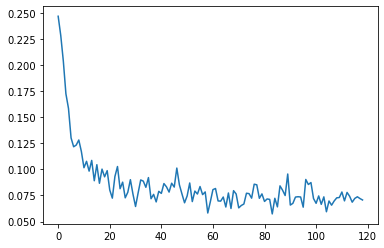

In [13]:
import matplotlib.pyplot as plt

%matplotlib inline
torch.save(model.state_dict(), "model_after_train.pt")

plt.plot(all_losses)

In [14]:
test_data = pd.concat([X_test, y_test], axis=1).reset_index()

total = len(test_data)
number_right = 0
model.eval()
with torch.no_grad():
    for idx, row in test_data.iterrows():
        text_parts = preprocess_text(str(row['text']))
        label = torch.tensor([row['fake']]).float().to(device)
        
        overall_output = torch.zeros((1,2)).to(device)
        try:
            for part in text_parts:
                if len(part) > 0:
                    overall_output += model(part.reshape(1, -1))[0]
        except RuntimeError:
            print("GPU out of memory, skipping this entry.")
            continue
            
        overall_output = F.softmax(overall_output[0], dim=-1)
            
        result = overall_output.max(0)[1].float().item()
 
        if result == label.item():
            number_right += 1
            
        if idx % print_every == 0 and idx > 0:
            print("{}/{}. Current accuracy: {}".format(idx, total, number_right / idx))
            
print("Accuracy on test data: {}".format(number_right / total))

300/8980. Current accuracy: 0.9666666666666667
600/8980. Current accuracy: 0.96
900/8980. Current accuracy: 0.9555555555555556
1200/8980. Current accuracy: 0.9583333333333334
1500/8980. Current accuracy: 0.96
1800/8980. Current accuracy: 0.9583333333333334
2100/8980. Current accuracy: 0.9595238095238096
2400/8980. Current accuracy: 0.96125
2700/8980. Current accuracy: 0.9607407407407408
3000/8980. Current accuracy: 0.9586666666666667
3300/8980. Current accuracy: 0.9596969696969697
3600/8980. Current accuracy: 0.9597222222222223
3900/8980. Current accuracy: 0.9584615384615385
4200/8980. Current accuracy: 0.9585714285714285
4500/8980. Current accuracy: 0.9577777777777777
4800/8980. Current accuracy: 0.9589583333333334
5100/8980. Current accuracy: 0.9584313725490196
5400/8980. Current accuracy: 0.9581481481481482
5700/8980. Current accuracy: 0.958421052631579
6000/8980. Current accuracy: 0.9581666666666667
6300/8980. Current accuracy: 0.9573015873015873
6600/8980. Current accuracy: 0.9583